In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = np.genfromtxt('stockdata.csv',delimiter=',')
df = np.log(df[1:,:-1])

In [3]:
df_ret = df[1:,:]-df[:-1,:]
stock =  df_ret[:251,0]

In [4]:
class calibrate:
    def __init__(self,stock_ret,T):
        self.r = np.sort(stock_ret)
        self.n = self.r.shape[0]
        self.dt = T/self.n
        self.qs = np.linspace(self.r[0],self.r[-1],max(100,self.n))
        self.qs2 = np.linspace(self.r[0]/2,self.r[-1]/2,max(50,self.n))
        
        self.ecdf = np.array([])
        for q in self.qs:
            self.ecdf=np.append(self.ecdf,sum(self.r<q)/self.n)
        
        epdfs = (self.ecdf[1:]-self.ecdf[:-1])/abs(self.qs[1]-self.qs[0])
        self.epdf = scipy.interpolate.interp1d(self.qs[:-1],epdfs,kind='cubic')(self.qs2)
        
        self.par = None
        
    def vg_pdf(self, xs,nu,theta,sigma):
        out = np.array([])
        for x in xs:
            g = np.linspace(0.001,100,1000)
            first = 1/(sigma*np.sqrt(2*np.pi*g))
            second = np.exp(-((x-theta*g)**2)/(g*2*sigma**2))
            third_num = (g**(self.dt/nu-1))*np.exp(-g/nu)
            third_den = nu**(self.dt/nu)*scipy.special.gamma(self.dt/nu)

            inte = first*second*third_num/third_den
            out = np.append(out,np.trapz(inte,g))
        return out
    
    def moving_average(self, data, window_size):
        smoothed_data = []
        for i in range(len(data)):
            window = data[max(0, i - window_size + 1):i + 1]
            smoothed_data.append(sum(window) / len(window))
        return smoothed_data
    
    def calibrate_VG(self,plot=False):
        self.par,_ = scipy.optimize.curve_fit(self.vg_pdf,self.qs2,self.epdf)
        fpdf = self.vg_pdf(self.qs2,self.par[0],self.par[1],self.par[2])
        if plot==True:
            plt.plot(self.qs2, fpdf,label='Fitted VG Pdf')
            plt.plot(self.qs2, self.epdf, label = 'Empirical Pdf')
            plt.legend()
        pass
    
    def params(self):
        if self.par is None:
            raise ValueError('Use calibrate_VG to fit the model.')
        pars = self.par
        nu,theta,sigma = pars[0],pars[1],pars[2]
        
        mup = 0.5*np.sqrt(theta**2+2*sigma**2/nu)+0.5*theta
        muq = mup-theta
        nup = mup**2*nu
        nuq = muq**2*nu
        
        lab1 = 'Regular Parametrization: nu='+str(nu)+', theta='+str(theta)+', sigma='+str(sigma)+'.'
        lab2 = 'Dec Parametrization: mup='+str(mup)+', muq='+str(muq)+', nup='+str(nup)+', nuq='+str(nuq)+'.'
        print(lab1+'\n'+lab2)
        return [nu,theta,sigma],[mup,muq,nup,nuq]
    
    def getter(self):
        if self.par is None:
            raise ValueError('Use calibrate_VG to fit the model.')
        fpdf = self.vg_pdf(self.qs2,self.par[0],self.par[1],self.par[2])
        return self.qs2, self.epdf, fpdf

In [5]:
c = calibrate(stock,1)

C:\Users\Michele\AppData\Local\Temp\ipykernel_6924\1247063289.py:25: RuntimeWarning: invalid value encountered in scalar power
  third_den = nu**(self.dt/nu)*scipy.special.gamma(self.dt/nu)


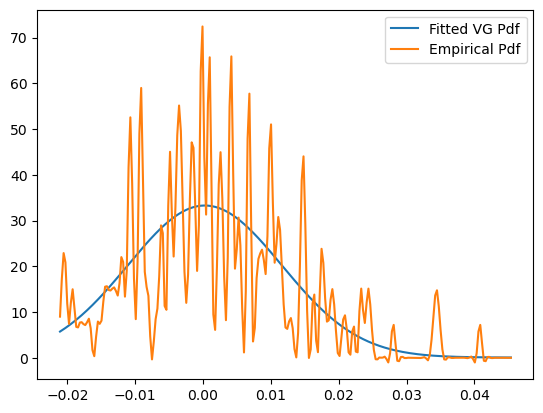

In [6]:
c.calibrate_VG(plot=True)

In [7]:
pars = c.params()

Regular Parametrization: nu=0.1899717541063861, theta=0.26514623236521734, sigma=0.3591142309196289.
Dec Parametrization: mup=0.7300699682109688, muq=0.4649237358457515, nup=0.10125535498961284, nuq=0.04106316976387411.


C:\Users\Michele\AppData\Local\Temp\ipykernel_6924\1247063289.py:25: RuntimeWarning: invalid value encountered in scalar power
  third_den = nu**(self.dt/nu)*scipy.special.gamma(self.dt/nu)
C:\Users\Michele\AppData\Local\Temp\ipykernel_6924\1247063289.py:24: RuntimeWarning: overflow encountered in exp
  third_num = (g**(self.dt/nu-1))*np.exp(-g/nu)
C:\Users\Michele\AppData\Local\Temp\ipykernel_6924\1247063289.py:27: RuntimeWarning: invalid value encountered in multiply
  inte = first*second*third_num/third_den


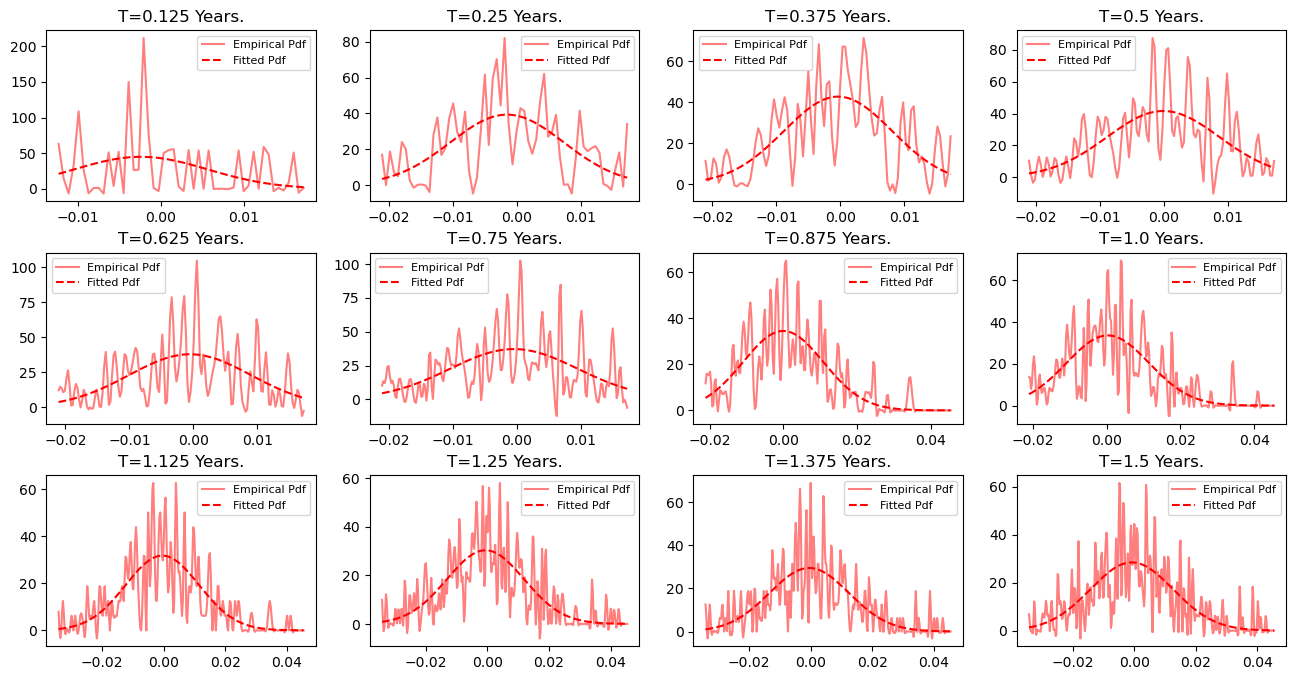

In [8]:
fig,ax = plt.subplots(3,4,figsize=(16,8),gridspec_kw={'hspace': 0.3})
for i in range(1,5):
    stock = df_ret[:int(252*i/8),0]
    c = calibrate(stock,i/8)
    c.calibrate_VG()
    q,e,f = c.getter()
    ax[0,i-1].plot(q,e,label='Empirical Pdf',c='red',alpha=0.5)
    ax[0,i-1].plot(q,f,'--',label='Fitted Pdf',c='red')
    title = 'T='+str(i/8)+' Years.'
    ax[0,i-1].set_title(title)
    ax[0,i-1].legend(fontsize = 8)
    
for i in range(5,9):
    stock = df_ret[:int(252*i/8),0]
    c = calibrate(stock,i/8)
    c.calibrate_VG()
    q,e,f = c.getter()
    ax[1,i-5].plot(q,e,label='Empirical Pdf',c='red',alpha=0.5)
    ax[1,i-5].plot(q,f,'--',label='Fitted Pdf',c='red')
    title = 'T='+str(i/8)+' Years.'
    ax[1,i-5].set_title(title)
    ax[1,i-5].legend(fontsize = 8)
    
for i in range(9,13):
    stock = df_ret[:int(252*i/8),0]
    c = calibrate(stock,i/8)
    c.calibrate_VG()
    q,e,f = c.getter()
    ax[2,i-9].plot(q,e,label='Empirical Pdf',c='red',alpha=0.5)
    ax[2,i-9].plot(q,f,'--',label='Fitted Pdf',c='red')
    title = 'T='+str(i/8)+' Years.'
    ax[2,i-9].set_title(title)
    ax[2,i-9].legend(fontsize = 8)